In [1]:
import os
import re
import sys
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import tensorflow as tf
from collections import defaultdict
from scipy.special import softmax
from scipy.stats import entropy
from scipy.signal import spectrogram
import gc

In [ ]:
results_combined = [r"E:\monitoring_data\sound_recordings\spot_1_original_spot\20072025-29072025_2R4W\results.csv", r"E:\monitoring_data\sound_recordings\spot_2_peacock_spot\20072025-03082025_2R4W\results.csv", r"E:\monitoring_data\sound_recordings\spot_4_yoga_spot\20072025-03082025_2R4W\results.csv", r"E:\monitoring_data\sound_recordings\spot_3_investigation_spot\20072025-03082025_2R4W\results.csv"]

In [ ]:
# NOT SURE IF NEEDED ANYMORE, now that we use a library directly
# -------------------- Load GPU Delegate --------------------
delegate = None
try:
    import tflite_runtime.interpreter as tflite
except ModuleNotFoundError:
    from tensorflow import lite as tflite

try:
    delegate = tf.lite.experimental.load_delegate("libtensorflowlite_gpu_delegate.so")
    print("GPU delegate loaded successfully.")
except Exception as e:
    print("GPU delegate not available:", e)

# -------------------- Patch Interpreter BEFORE importing wrapper --------------------
if not hasattr(tflite, "_original_interpreter"):
    tflite._original_interpreter = tflite.Interpreter

    def Interpreter_with_delegate(*args, **kwargs):
        if delegate is not None:
            kwargs["experimental_delegates"] = [delegate]
        return tflite._original_interpreter(*args, **kwargs)

    tflite.Interpreter = Interpreter_with_delegate

Exception ignored in: <function Delegate.__del__ at 0x0000027E7B496660>
Traceback (most recent call last):
  File "c:\Users\DELL\anaconda3\envs\an\Lib\site-packages\tensorflow\lite\python\interpreter.py", line 121, in __del__
    if self._library is not None:
       ^^^^^^^^^^^^^
AttributeError: 'Delegate' object has no attribute '_library'


GPU delegate not available: Could not find module 'libtensorflowlite_gpu_delegate.so' (or one of its dependencies). Try using the full path with constructor syntax.


Aggregated Data for PCA:
      Spot  Segment       ADI         ACI       AEI      NDSI       CLS
0   Spot 1      Day  3.123002  293.132622  0.373256  0.217771  0.744635
1   Spot 1  Evening  3.699303  283.211857  0.667976  0.081274  0.670522
2   Spot 1  Morning  2.655184  300.671104  0.465612  0.296220  0.699595
3   Spot 1    Night  3.315951  252.963735  0.540811 -0.094885  0.751667
4   Spot 2      Day  2.996768  335.762436  0.510097 -0.375293  0.675776
5   Spot 2  Evening  2.629582  202.886847  0.459111  0.076061  0.775799
6   Spot 2  Morning  2.682655  286.312089  0.434286  0.119639  0.691727
7   Spot 2    Night  3.496858  297.586041  0.427080  0.036363  0.757244
8   Spot 3      Day  3.081190  264.036952  0.396215 -0.390886  0.722659
9   Spot 3  Evening  2.571501  328.497819  0.462476 -0.069526  0.787516
10  Spot 3  Morning  2.934931  393.205775  0.424174  0.098364  0.740193
11  Spot 3    Night  3.367154  327.917104  0.458854  0.124372  0.750257
12  Spot 4      Day  3.615271  289.0782

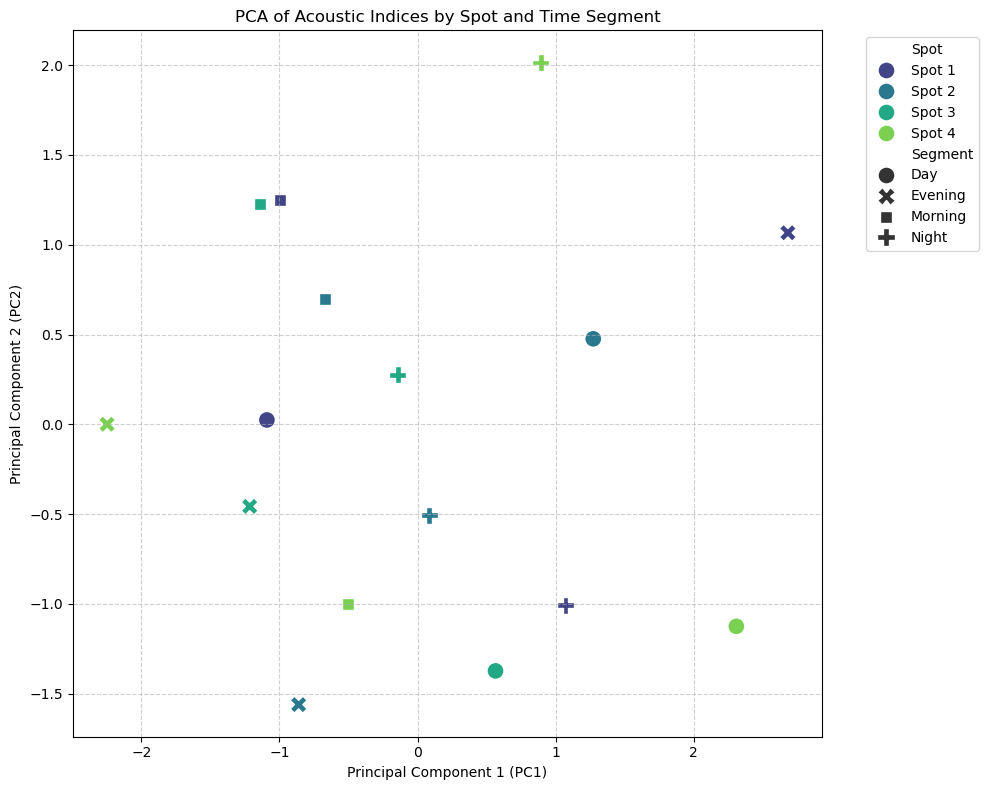

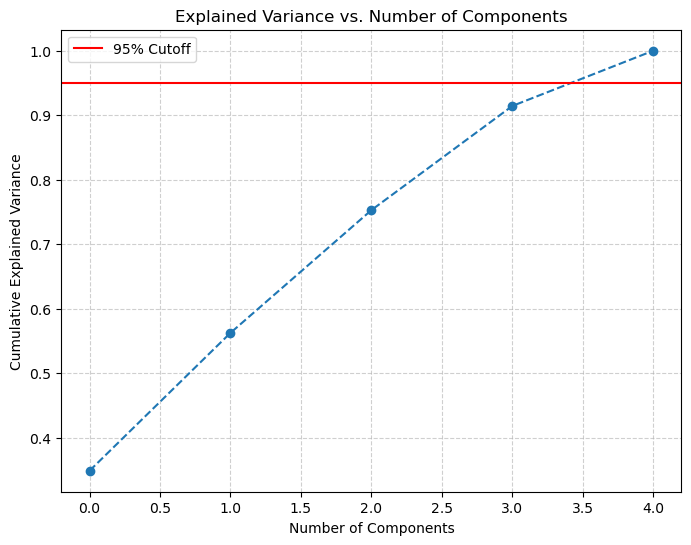

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# --- IMPORTANT: PLACEHOLDER FOR YOUR DATA ---
# This list should contain the actual file paths to your CSVs for each spot.
# For example, if your files are named 'spot1.csv', 'spot2.csv', etc.
# results_combined = ['path/to/spot1.csv', 'path/to/spot2.csv', 'path/to/spot3.csv', 'path/to/spot4.csv']
#
# Since I don't have access to your file system, the following line is a placeholder
# that assumes the files exist in the same directory as the script.

# results_combined = [f"spot{i+1}_indices.csv" for i in range(4)]

# Check if placeholder files exist before proceeding, in case this script is run standalone

# if not all(os.path.exists(f) for f in results_combined):
#     print("Warning: CSV files not found. Generating placeholder data for demonstration.")
#     print("Please replace the 'results_combined' list with your actual file paths.")
#     for i, file_path in enumerate(results_combined):
#         data = {
#             'Hour': np.arange(24),
#             'ADI': np.random.uniform(1.0, 5.0, 24),
#             'ACI': np.random.uniform(100, 500, 24),
#             'AEI': np.random.uniform(0.1, 0.9, 24),
#             'NDSI': np.random.uniform(-1.0, 1.0, 24),
#             'RSP': np.random.uniform(0, 1, 24),
#             'EVN': np.random.uniform(0, 1, 24),
#             'CLS': np.random.uniform(0.5, 1.0, 24),
#             'MFC': np.random.uniform(0, 1000, 24)
#         }
#         df_temp = pd.DataFrame(data)
#         df_temp.to_csv(file_path, index=False)


# -------------------- Step 1: Data Consolidation --------------------
all_data = []
for i, file_path in enumerate(results_combined):
    df_spot = pd.read_csv(file_path)
    # Add a 'Spot' column to identify the source of the data
    df_spot['Spot'] = f'Spot {i+1}'
    all_data.append(df_spot)

# Concatenate all DataFrames into a single master DataFrame
master_df = pd.concat(all_data, ignore_index=True)

# -------------------- Step 2: Segment Mapping --------------------
def map_to_segment(hour):
    if 21 <= hour or hour < 5:
        return 'Night'
    elif 5 <= hour < 10:
        return 'Morning'
    elif 10 <= hour < 17:
        return 'Day'
    else:  # 17 to 21
        return 'Evening'

master_df['Segment'] = master_df['Hour'].apply(map_to_segment)

# -------------------- Step 3: Aggregation for PCA --------------------
# Define the list of indices to be included in the PCA
acoustic_indices = ['ADI', 'ACI', 'AEI', 'NDSI', 'CLS']

# Group by 'Spot' and 'Segment' and calculate the mean for each index
df_pca = master_df.groupby(['Spot', 'Segment'])[acoustic_indices].mean().reset_index()

print("Aggregated Data for PCA:")
print(df_pca)
print("\n")

# -------------------- Step 4: Scaling and PCA --------------------
# Select the features for PCA
features = df_pca[acoustic_indices]

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA with two principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# -------------------- Step 5: Combining and Visualization --------------------
# Add 'Spot' and 'Segment' back to the PCA results
final_pca_df = pd.concat([df_pca[['Spot', 'Segment']], pca_df], axis=1)

print("Final PCA Results:")
print(final_pca_df)

# Visualization of PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=final_pca_df,
    x='PC1',
    y='PC2',
    hue='Spot',        # Color points by Spot
    style='Segment',   # Differentiate markers by Time Segment
    s=150,             # Set marker size
    palette='viridis'  # Choose a color palette
)

plt.title('PCA of Acoustic Indices by Spot and Time Segment')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional: Explained variance plot to choose number of components
pca_full = PCA()
pca_full.fit(scaled_features)
explained_variance = pca_full.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Cutoff')
plt.legend()
plt.show()


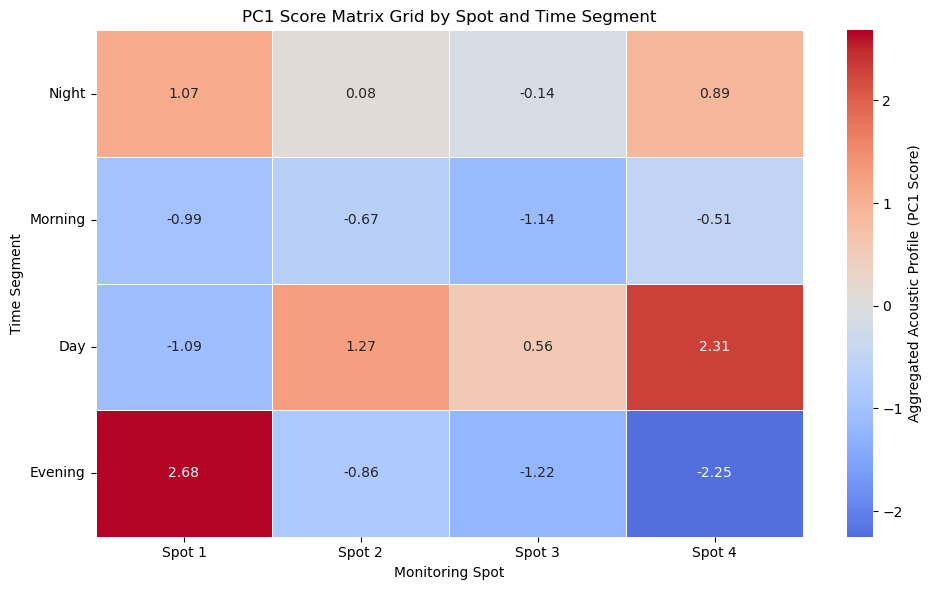

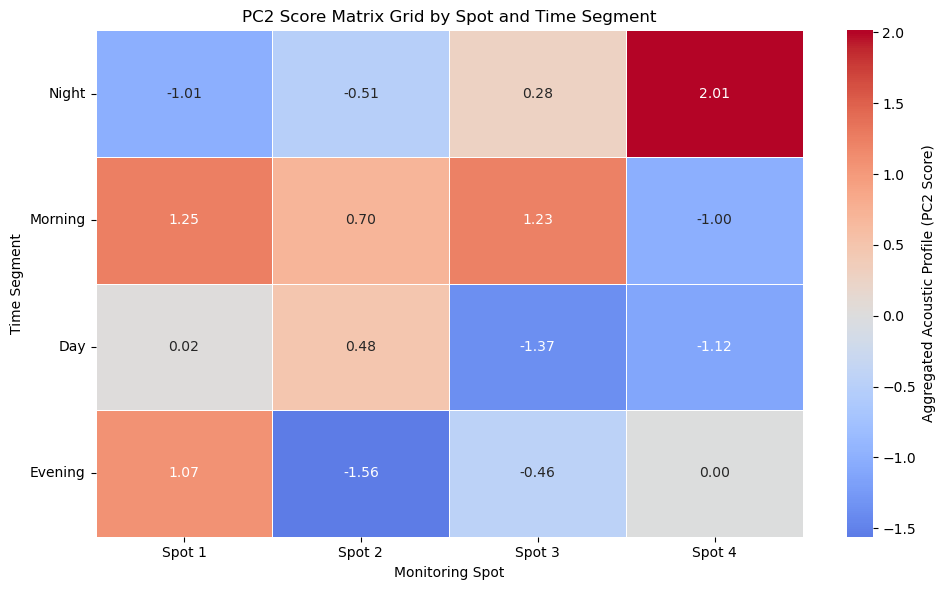

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# --- IMPORTANT: Placeholder for your data ---
# This list should contain the actual file paths to your CSVs for each spot.
# Since I don't have access to your file system, the following line is a placeholder
# that assumes the files exist in the same directory as the script.

# results_combined = [f"spot{i+1}_indices.csv" for i in range(4)]

# Check if placeholder files exist before proceeding, in case this script is run standalone

# if not all(os.path.exists(f) for f in results_combined):
#     print("Warning: CSV files not found. Generating placeholder data for demonstration.")
#     print("Please replace the 'results_combined' list with your actual file paths.")
#     for i, file_path in enumerate(results_combined):
#         data = {
#             'Hour': np.arange(24),
#             'ADI': np.random.uniform(1.0, 5.0, 24),
#             'ACI': np.random.uniform(100, 500, 24),
#             'AEI': np.random.uniform(0.1, 0.9, 24),
#             'NDSI': np.random.uniform(-1.0, 1.0, 24),
#             'RSP': np.random.uniform(0, 1, 24),
#             'EVN': np.random.uniform(0, 1, 24),
#             'CLS': np.random.uniform(0.5, 1.0, 24),
#             'MFC': np.random.uniform(0, 1000, 24)
#         }
#         df_temp = pd.DataFrame(data)
#         df_temp.to_csv(file_path, index=False)

# -------------------- Step 1: Data Consolidation --------------------
all_data = []
for i, file_path in enumerate(results_combined):
    df_spot = pd.read_csv(file_path)
    # Add a 'Spot' column to identify the source of the data
    df_spot['Spot'] = f'Spot {i+1}'
    all_data.append(df_spot)

master_df = pd.concat(all_data, ignore_index=True)

# -------------------- Step 2: Segment Mapping --------------------
def map_to_segment(hour):
    if 21 <= hour or hour < 5:
        return 'Night'
    elif 5 <= hour < 10:
        return 'Morning'
    elif 10 <= hour < 17:
        return 'Day'
    else:  # 17 to 21
        return 'Evening'

master_df['Segment'] = master_df['Hour'].apply(map_to_segment)

# -------------------- Step 3: Aggregation for PCA --------------------
acoustic_indices = ['ADI', 'ACI', 'AEI', 'NDSI', 'CLS']
df_pca = master_df.groupby(['Spot', 'Segment'])[acoustic_indices].mean().reset_index()

# -------------------- Step 4: Scaling and PCA --------------------
features = df_pca[acoustic_indices]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
final_pca_df = pd.concat([df_pca[['Spot', 'Segment']], pca_df], axis=1)


# -------------------- Step 5: Create the PCA Matrix Grid --------------------
# Create two pivot tables, one for PC1 and one for PC2
pc1_grid = final_pca_df.pivot(index='Segment', columns='Spot', values='PC1')
pc2_grid = final_pca_df.pivot(index='Segment', columns='Spot', values='PC2')

# Reorder the index to match the time segments
segment_order = ['Night', 'Morning', 'Day', 'Evening']
pc1_grid = pc1_grid.reindex(segment_order)
pc2_grid = pc2_grid.reindex(segment_order)

# -------------------- Step 6: Visualize the Matrix Grids --------------------

# --- Heatmap for PC1 ---
plt.figure(figsize=(10, 6))
sns.heatmap(
    pc1_grid,
    annot=True,          # Show the numerical values
    fmt=".2f",           # Format to two decimal places
    cmap="coolwarm",     # Use a diverging color palette
    center=0,            # Center the color scale at 0
    linewidths=.5,
    cbar_kws={'label': 'Aggregated Acoustic Profile (PC1 Score)'}
)
plt.title('PC1 Score Matrix Grid by Spot and Time Segment')
plt.xlabel('Monitoring Spot')
plt.ylabel('Time Segment')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Heatmap for PC2 ---
plt.figure(figsize=(10, 6))
sns.heatmap(
    pc2_grid,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=.5,
    cbar_kws={'label': 'Aggregated Acoustic Profile (PC2 Score)'}
)
plt.title('PC2 Score Matrix Grid by Spot and Time Segment')
plt.xlabel('Monitoring Spot')
plt.ylabel('Time Segment')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

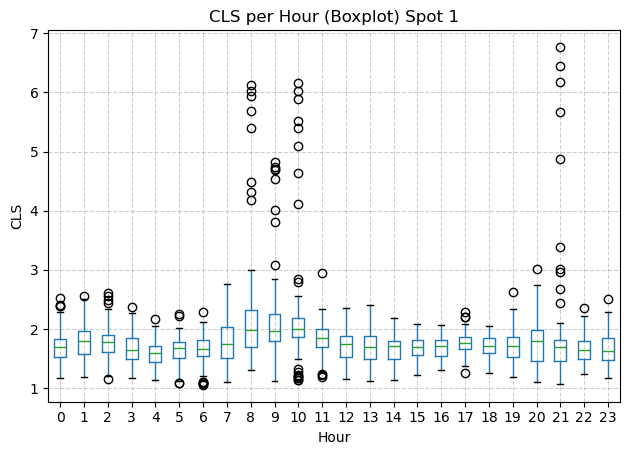

<Figure size 1200x600 with 0 Axes>

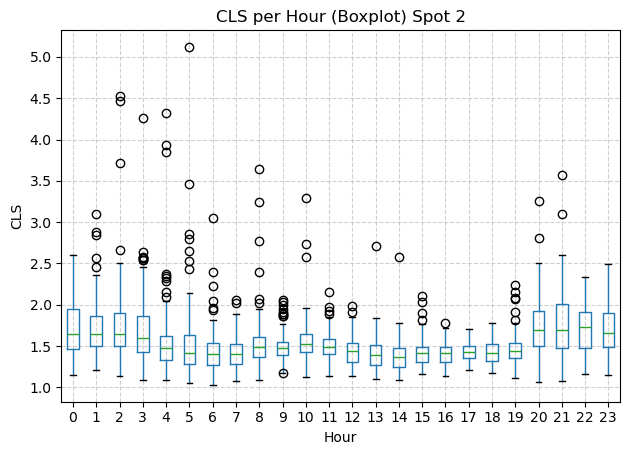

<Figure size 1200x600 with 0 Axes>

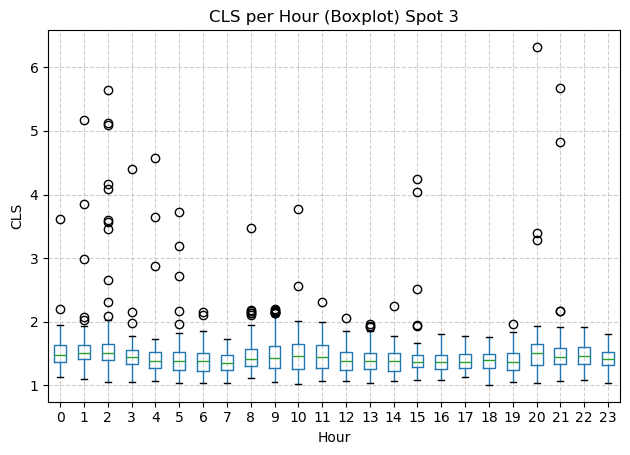

<Figure size 1200x600 with 0 Axes>

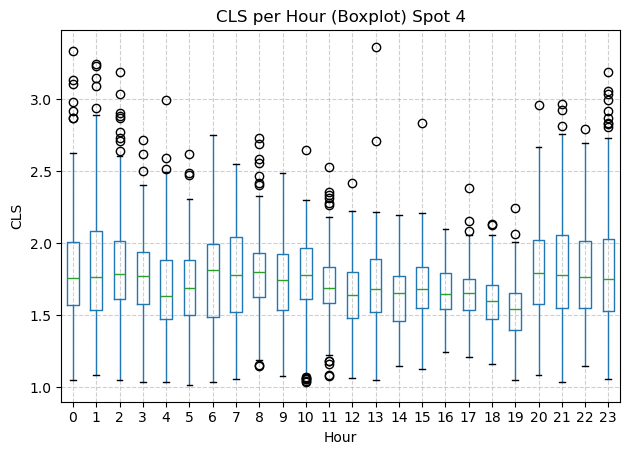

In [6]:
# -------------------- Boxplot Visualization --------------------
# Create boxplots for each index (Confidence, ADI, ACI, AEI, NDSI) by Hour.

for i in range(len(results_combined)):
    plt.figure(figsize=(12, 6))
    pd.read_csv(results_combined[i]).boxplot(column="CLS", by="Hour", grid=True)
    plt.title(f"CLS per Hour (Boxplot) Spot {i+1}")
    plt.suptitle("")
    plt.xlabel("Hour")
    plt.ylabel("CLS")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    # plt.savefig(f"boxplot _per_hour.png")
    plt.show()

### Part 2: Generation of BirdNet predictions

- **Generating Lat-Long specific species list**
- **Predictions** Gives one bird for one 3 second segment if detected (also no bird for some segments) with a confidence score


In [15]:
!python "E:\archive\BirdNET-Analyzer\analyze.py" --i "E:\Sanjay_Van_Monitoring\Origin Spot\02062025-13062025_30R30W\recordings\04213SPOT1_20250602_120000.wav" --o "E:\Sanjay_Van_Monitoring\Origin Spot\02062025-13062025_30R30W\BirdNET_Temp_Results" --lat 28.53 --lon 77.18 --week 24 --min_conf 0.5 --rtype csv


Species list contains 191 species
Analyzing E:\Sanjay_Van_Monitoring\Origin Spot\02062025-13062025_30R30W\recordings\04213SPOT1_20250602_120000.wav
Error: Cannot open audio file E:\Sanjay_Van_Monitoring\Origin Spot\02062025-13062025_30R30W\recordings\04213SPOT1_20250602_120000.wav


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [16]:
import librosa
audio, sr = librosa.load(r"E:\Sanjay_Van_Monitoring\Origin Spot\02062025-13062025_30R30W\recordings\04213SPOT1_20250602_120000.wav", sr=None)
print(f"Loaded successfully with sample rate: {sr}")

Loaded successfully with sample rate: 44100


In [19]:
!python E:\archive\BirdNET-Analyzer\species.py --lat 28.53 --lon 77.18 --week 24 --sf_thresh 0.1 "E:\species_list.txt"


usage: species.py [-h] [--o O] [--lat LAT] [--lon LON] [--week WEEK]
                  [--threshold THRESHOLD] [--sortby SORTBY]
species.py: error: unrecognized arguments: --sf_thresh 0.1 E:\species_list.txt


In [22]:
import subprocess

# Path to BirdNET Analyzer directory and species.py script
script_path = r"E:\archive\BirdNET-Analyzer\species.py"

# Output file path where species list will be saved
output_file = r"E:\species_list.txt"

# Set the location, week, and threshold
lat = "28.53"
lon = "77.18"
week = "24"
threshold = "0.05"

# Build the command
command = [
    sys.executable, script_path,
    "--lat", lat,
    "--lon", lon,
    "--week", week,
    "--threshold", threshold,
    "--o", output_file
]

# Run the command
try:
    subprocess.run(command, check=True)
    print(f"✅ Species list written to: {output_file}")
except subprocess.CalledProcessError as e:
    print("❌ Failed to generate species list:")
    print(e.stderr)


✅ Species list written to: E:\species_list.txt


In [8]:
!pip install birdnetlib --trusted-host pypi.org --trusted-host files.pythonhosted.org




   ---------------------------------------- 0.0/61.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/61.1 MB 5.6 MB/s eta 0:00:11
   ---------------------------------------- 0.6/61.1 MB 6.0 MB/s eta 0:00:11
    --------------------------------------- 1.0/61.1 MB 8.3 MB/s eta 0:00:08
    --------------------------------------- 1.0/61.1 MB 8.3 MB/s eta 0:00:08
    --------------------------------------- 1.0/61.1 MB 8.3 MB/s eta 0:00:08
    --------------------------------------- 1.4/61.1 MB 4.8 MB/s eta 0:00:13
   - -------------------------------------- 2.3/61.1 MB 6.5 MB/s eta 0:00:09
   -- ------------------------------------- 3.1/61.1 MB 8.4 MB/s eta 0:00:07
   -- ------------------------------------- 3.1/61.1 MB 8.4 MB/s eta 0:00:07
   -- ------------------------------------- 3.1/61.1 MB 8.4 MB/s eta 0:00:07
   -- ------------------------------------- 3.1/61.1 MB 8.4 MB/s eta 0:00:07
   -- ------------------------------------- 3.1/61.1 MB 8.4 MB/s eta 0:00:07
   -- 

In [13]:
!pip install resampy --trusted-host pypi.org --trusted-host files.pythonhosted.org

   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
    --------------------------------------- 0.1/3.1 MB 1.7 MB/s eta 0:00:02
   - -------------------------------------- 0.1/3.1 MB 1.7 MB/s eta 0:00:02
   --- ------------------------------------ 0.3/3.1 MB 2.4 MB/s eta 0:00:02
   ----------- ---------------------------- 0.9/3.1 MB 4.9 MB/s eta 0:00:01
   ------------------------ --------------- 1.9/3.1 MB 9.1 MB/s eta 0:00:01
   ------------------------------------- -- 2.8/3.1 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 3.1/3.1 MB 10.9 MB/s eta 0:00:00


In [38]:
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime


import os
import re
import sys
import pandas as pd
import subprocess
import numpy as np
np.complex = complex  # Monkey patch for compatibility
import librosa
import soundfile as sf


TARGET_SR = 48000
SNR_DB = 18

# ==================== DENOISING FUNCTION ====================
def remove_static_noise(audio, noise_ref, sr=TARGET_SR, snr_db=SNR_DB):
    if len(noise_ref) > len(audio):
        noise_ref = noise_ref[:len(audio)]
    else:
        noise_ref = np.pad(noise_ref, (0, len(audio) - len(noise_ref)), 'wrap')
    audio_power = np.mean(audio ** 2)
    noise_power = np.mean(noise_ref ** 2)
    desired_noise_power = audio_power / (10 ** (snr_db / 10))
    noise_ref_scaled = noise_ref * np.sqrt(desired_noise_power / noise_power)
    audio_td = audio - noise_ref_scaled
    stft = librosa.stft(audio_td, n_fft=2048, hop_length=512)
    magnitude, phase = np.abs(stft), np.angle(stft)
    noise_stft = librosa.stft(noise_ref, n_fft=2048, hop_length=512)
    noise_mag = np.abs(noise_stft)
    noise_threshold = np.mean(noise_mag, axis=1, keepdims=True) * 1.2
    gated_mag = np.where(magnitude > noise_threshold, magnitude, 0)
    cleaned_stft = gated_mag * np.exp(1j * phase)
    return librosa.istft(cleaned_stft, hop_length=512)

# ==================== LOAD STATIC NOISE CLIP ====================
STATIC_NOISE_PATH = r"E:\projects\acoustic_biodiversity\static_noise.wav"
noise_clip, _ = librosa.load(STATIC_NOISE_PATH, sr=TARGET_SR)

import tempfile
def analyze_bird_audio(audio_path, lat, lon):
    # Step 1: Load audio with original sampling rate
    audio_raw, orig_sr = librosa.load(audio_path, sr=None)
    
    # Step 2: Resample if needed
    if orig_sr != TARGET_SR:
        audio_raw = librosa.resample(y=audio_raw, orig_sr=orig_sr, target_sr=TARGET_SR)

    
    # Step 3: Denoise
    final_sound = remove_static_noise(audio_raw, noise_clip, sr=TARGET_SR, snr_db=SNR_DB)

    # Step 4: Save to temp WAV file
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmpfile:
        sf.write(tmpfile.name, final_sound, samplerate=TARGET_SR)
        tmp_audio_path = tmpfile.name

    # Step 5: Analyze with BirdNET
    analyzer = Analyzer()
    recording = Recording(
        analyzer,
        tmp_audio_path,
        lat=lat,
        lon=lon,
        #date=date,
        #min_conf=min_conf,
    )
    recording.analyze()
    
    return pd.DataFrame(recording.detections)

# def analyze_bird_audio(audio_path, lat, lon, date, min_conf=0.3):
#     audio_raw, orig_sr = librosa.load(audio_path, sr=None)  # Load at original sampling rate

#     # Step 2: Resample if needed
#     if orig_sr != TARGET_SR:
#         audio_raw = librosa.resample(y=audio_raw, orig_sr=orig_sr, target_sr=TARGET_SR)

#     # Step 3: Denoise
#     final_sound = remove_static_noise(audio_raw, noise_clip, sr=TARGET_SR, snr_db=SNR_DB)

#     # Step 4: Analyze
#     analyzer = Analyzer()
#     recording = Recording(
#         analyzer,
#         final_sound,
#         lat=lat,
#         lon=lon,
#         date=date,
#         min_conf=min_conf,
#     )
#     recording.analyze()

#     # Convert list of detections to DataFrame
#     return pd.DataFrame(recording.detections)



In [ ]:


detections_df = analyze_bird_audio(
    audio_path=r"E:\monitoring_data\sound_recordings\spot_1_original_spot\21062025-05072025_5R5W\recordings\04213SPOT1_20250621_081000.wav",
    lat=28.53,
    lon=77.18,
    # date="2024-06-12",  # Required in BirdNET
    #min_conf=0.3
)

print(detections_df.head())  # Preview top results




Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data
read_audio_data: complete, read  100 chunks.
analyze_recording tmp9b2d608i.wav
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
-1
386 species loaded.


c:\Users\DELL\anaconda3\envs\an\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


         common_name       scientific_name  start_time  end_time  confidence  \
0     Indian Peafowl        Pavo cristatus         0.0       3.0    0.112918   
1     Indian Peafowl        Pavo cristatus         3.0       6.0    0.189154   
2     Indian Peafowl        Pavo cristatus         6.0       9.0    0.414781   
3     Indian Peafowl        Pavo cristatus         9.0      12.0    0.308975   
4  Large-billed Crow  Corvus macrorhynchos        15.0      18.0    0.126842   

                                    label  
0           Pavo cristatus_Indian Peafowl  
1           Pavo cristatus_Indian Peafowl  
2           Pavo cristatus_Indian Peafowl  
3           Pavo cristatus_Indian Peafowl  
4  Corvus macrorhynchos_Large-billed Crow  


In [46]:
DATASETS = [r"E:\monitoring_data\sound_recordings\spot_1_original_spot\20072025-29072025_2R4W\recordings", r"E:\monitoring_data\sound_recordings\spot_2_peacock_spot\20072025-03082025_2R4W\recordings", r"E:\monitoring_data\sound_recordings\spot_4_yoga_spot\20072025-03082025_2R4W\recordings", r"E:\monitoring_data\sound_recordings\spot_3_investigation_spot\20072025-03082025_2R4W\recordings"]
OUTPUTS = [r"E:\monitoring_data\sound_recordings\spot_1_original_spot\20072025-29072025_2R4W\birdnet_classification.csv", r"E:\monitoring_data\sound_recordings\spot_2_peacock_spot\20072025-03082025_2R4W\birdnet_classification.csv", r"E:\monitoring_data\sound_recordings\spot_4_yoga_spot\20072025-03082025_2R4W\birdnet_classification.csv", r"E:\monitoring_data\sound_recordings\spot_3_investigation_spot\20072025-03082025_2R4W\birdnet_classification.csv"]

In [ ]:
# THIS IS THE FINAL PREDICTIONS FUNCTION
# IT GIVES A REALLY HUGE CELL OUTPUT SO THAT NEEDS TO BE CHANGED TO ONE LIKE PER FILE HOPEFULLY
import os
import re
import pandas as pd

# Your function to extract datetime components
def extract_year_month_date_hour_and_minute(filename):
    match_date = re.search(r'_(\d{8})_', filename)
    match = re.search(r'_(\d{6})\.wav$', filename)
    if match and match_date:
        time_str = match.group(1)
        date_str = match_date.group(1)
        year = date_str[:4]
        month = date_str[4:6]
        day = date_str[6:]
        hour = int(time_str[:2])
        minute = int(time_str[2:4])
        return year, month, day, hour, minute
    return None, None, None, None, None

# Directory containing WAV recordings

for i in range(4):
    # Store all detections
    all_detections = []

    # Loop through all .wav files
    for fname in os.listdir(DATASETS[i]):
        if fname.lower().endswith(".wav"):
            filepath = os.path.join(DATASETS[i], fname)

            # Extract date from filename (required by BirdNET)
            year, month, day, hour, minute = extract_year_month_date_hour_and_minute(fname)
            if None in [year, month, day]:
                print(f"Skipping file due to unmatched filename format: {fname}")
                continue

            # Format as YYYY-MM-DD
            date_str = f"{year}-{month}-{day}"

            try:
                # Run BirdNET analysis
                detections_df = analyze_bird_audio(
                    audio_path=filepath,
                    lat=28.53,
                    lon=77.18
                    # date=date_str,
                    # min_conf=0.3
                )

                # Add filename and datetime columns
                detections_df["filename"] = fname
                detections_df["year"] = year
                detections_df["month"] = month
                detections_df["day"] = day
                detections_df["hour"] = hour
                detections_df["minute"] = minute

                all_detections.append(detections_df)

                # ✅ Print progress
                print(f"Processed file: {fname} with {len(detections_df)} detections.")

            except Exception as e:
                print(f"Error processing {fname}: {e}")

    # Combine all detections
    if all_detections:
        final_df = pd.concat(all_detections, ignore_index=True)
        final_df.to_csv(OUTPUTS[i], index=False)
        print("Saved detections to 'birdnet_detections_all.csv'")
    else:
        print("No detections processed.")


In [2]:
import pandas as pd
DATASETS = [r"E:\monitoring_data\sound_recordings\spot_1_original_spot\20072025-29072025_2R4W\birdnet_classification.csv", r"E:\monitoring_data\sound_recordings\spot_2_peacock_spot\20072025-03082025_2R4W\birdnet_classification.csv", r"E:\monitoring_data\sound_recordings\spot_4_yoga_spot\20072025-03082025_2R4W\birdnet_classification.csv", r"E:\monitoring_data\sound_recordings\spot_3_investigation_spot\20072025-03082025_2R4W\birdnet_classification.csv"]


# Read each CSV into a DataFrame
dataset_list = [pd.read_csv(file) for file in DATASETS]

# Concatenate into one DataFrame
data = pd.concat(dataset_list, ignore_index=True)

# (Optional) Save the combined DataFrame to a new CSV
# combined_df.to_csv("combined.csv", index=False)

print(data.head())


         common_name      scientific_name  start_time  end_time  confidence  \
0  Common Tailorbird  Orthotomus sutorius         0.0       3.0    0.122334   
1     Jungle Babbler        Argya striata         3.0       6.0    0.369348   
2     Jungle Babbler        Argya striata         9.0      12.0    0.379663   
3     Jungle Babbler        Argya striata        12.0      15.0    0.407963   
4     Indian Peafowl       Pavo cristatus         0.0       3.0    0.106279   

                                   label                        filename  \
0  Orthotomus sutorius_Common Tailorbird  04213SPOT1_20250720_074253.wav   
1           Argya striata_Jungle Babbler  04213SPOT1_20250720_074253.wav   
2           Argya striata_Jungle Babbler  04213SPOT1_20250720_074253.wav   
3           Argya striata_Jungle Babbler  04213SPOT1_20250720_074253.wav   
4          Pavo cristatus_Indian Peafowl  04213SPOT1_20250720_074800.wav   

   year  month  day  hour  minute  
0  2025      7   20     7      4

In [3]:
len(data["common_name"].unique())

305

In [4]:
data["common_name"].unique()

array(['Common Tailorbird', 'Jungle Babbler', 'Indian Peafowl',
       'White-breasted Waterhen', 'Black Drongo', 'Long-tailed Shrike',
       'Common Hawk-Cuckoo', 'Indian Pitta', 'Purple Sunbird',
       'Alexandrine Parakeet', 'Large Cuckooshrike',
       'Indian Golden Oriole', 'Red-whiskered Bulbul',
       'Rose-ringed Parakeet', 'Indian Paradise-Flycatcher',
       'Common Myna', 'Asian Emerald Dove', 'Gray Francolin',
       'White-throated Kingfisher', 'Asian Koel', 'Large-billed Crow',
       'Greater Coucal', 'Blue-throated Flycatcher',
       'Gray-breasted Prinia', 'Common Iora', 'Gray-bellied Cuckoo',
       'Red-wattled Lapwing', 'Brown-headed Barbet',
       'Indian Gray Hornbill', 'Savanna Nightjar', 'Ashy Prinia',
       'Stork-billed Kingfisher', 'Indian Cuckoo', 'Baya Weaver',
       'Red-vented Bulbul', 'House Crow', 'Common Kingfisher',
       'Rufous Treepie', 'Oriental Magpie-Robin', 'Indian White-eye',
       'Black-rumped Flameback', 'Little Swift',
       'Fu

In [5]:
# Get unique common names
unique_names = data["label"].dropna().unique()

# Save to a text file
with open("unique_common_names.txt", "w", encoding="utf-8") as f:
    for name in unique_names:
        f.write(name + "\n")


In [26]:
data["common_name"].value_counts()

common_name
White-breasted Waterhen    11318
Indian Peafowl              9395
Common Hawk-Cuckoo          8962
Common Tailorbird           7619
Brown-headed Barbet         7112
                           ...  
Green Sandpiper                1
Red-billed Blue-Magpie         1
Black Redstart                 1
Long-tailed Minivet            1
Northern Pintail               1
Name: count, Length: 207, dtype: int64

In [ ]:
result

### Part 7: Validation of Output 

- **Confusion Matrix** This gives all the values needed for the confusion matrix
- The latest species list is generated from unique bird names from combined_df in graph_spot3_4
- The 222 validation bird list has been created from eBird and is considered as ground truth since it is the same list on Myna


In [6]:

import re
from collections import defaultdict

# --- DATA INPUT ---
# The raw text data variables will be placed here.
# I'm omitting them for brevity in this response, but they are the same as before.

ebird_raw_text = """
Lesser Whistling Duck Dendrocygna javanica
Bar-headed Goose Anser indicus
Greylag Goose Anser anser
Knob-billed Duck Sarkidiornis melanotos
Ruddy Shelduck Tadorna ferruginea
Cotton Pygmy Goose Nettapus coromandelianus
Garganey Spatula querquedula
Northern Shoveler Spatula clypeata
Gadwall Mareca strepera
Eurasian Wigeon Mareca penelope
Indian Spot-billed Duck Anas poecilorhyncha
Mallard Anas platyrhynchos
Northern Pintail Anas acuta
Common Teal Anas crecca
Red-crested Pochard Netta rufina
Common Pochard Aythya ferina
Ferruginous Duck Aythya nyroca
Tufted Duck Aythya fuligula
Indian Peafowl Pavo cristatus
Grey Francolin Ortygornis pondicerianus
Black Francolin Francolinus francolinus
Jungle Bush Quail Perdicula asiatica
Little Grebe Tachybaptus ruficollis
Rock Pigeon Columba livia
Oriental Turtle Dove Streptopelia orientalis
Eurasian Collared Dove Streptopelia decaocto
Red Collared Dove Streptopelia tranquebarica
Spotted Dove Spilopelia chinensis
Laughing Dove Spilopelia senegalensis
Yellow-footed Green Pigeon Treron phoenicopterus
Greater Coucal Centropus sinensis
Sirkeer Malkoha Taccocua leschenaultii
Pied Cuckoo Clamator jacobinus
Asian Koel Eudynamys scolopaceus
Grey-bellied Cuckoo Cacomantis passerinus
Common Hawk Cuckoo Hierococcyx varius
Jungle Nightjar Caprimulgus indicus
Little Swift Apus affinis
Common Moorhen Gallinula chloropus
Eurasian Coot Fulica atra
Grey-headed Swamphen Porphyrio poliocephalus
Watercock Gallicrex cinerea
White-breasted Waterhen Amaurornis phoenicurus
Brown Crake Zapornia akool
Indian Thick-knee Burhinus indicus
Black-winged Stilt Himantopus himantopus
Pied Avocet Recurvirostra avosetta
Little Ringed Plover Charadrius dubius
River Lapwing Vanellus duvaucelii
Yellow-wattled Lapwing Vanellus malabaricus
Red-wattled Lapwing Vanellus indicus
White-tailed Lapwing Vanellus leucurus
Greater Painted-snipe Rostratula benghalensis
Common Sandpiper Actitis hypoleucos
Green Sandpiper Tringa ochropus
Marsh Sandpiper Tringa stagnatilis
Wood Sandpiper Tringa glareola
Common Redshank Tringa totanus
Spotted Redshank Tringa erythropus
Common Greenshank Tringa nebularia
Ruff Calidris pugnax
Temminck's Stint Calidris temminckii
Little Stint Calidris minuta
Barred Buttonquail Turnix suscitator
Whiskered Tern Chlidonias hybrida
Asian Openbill Anastomus oscitans
Painted Stork Mycteria leucocephala
Little Cormorant Microcarbo niger
Great Cormorant Phalacrocorax carbo
Indian Cormorant Phalacrocorax fuscicollis
Black-crowned Night Heron Nycticorax nycticorax
Little Egret Egretta garzetta
Indian Pond Heron Ardeola grayii
Eastern Cattle Egret Bubulcus coromandus
Great Egret Ardea alba
Intermediate Egret Ardea intermedia
Grey Heron Ardea cinerea
Purple Heron Ardea purpurea
Glossy Ibis Plegadis falcinellus
Black-headed Ibis Threskiornis melanocephalus
Red-naped Ibis Pseudibis papillosa
Black-winged Kite Elanus caeruleus
Egyptian Vulture Neophron percnopterus
Oriental Honey Buzzard Pernis ptilorhynchus
Crested Serpent-Eagle Spilornis cheela
Short-toed Snake-Eagle Circaetus gallicus
Black Eagle Ictinaetus malaiensis
Indian Spotted Eagle Clanga hastata
Greater Spotted Eagle Clanga clanga
Booted Eagle Hieraaetus pennatus
Tawny Eagle Aquila rapax
Steppe Eagle Aquila nipalensis
Eastern Imperial Eagle Aquila heliaca
Bonelli's Eagle Aquila fasciata
White-eyed Buzzard Butastur teesa
Western Marsh Harrier Circus aeruginosus
Shikra Accipiter badius
Besra Accipiter virgatus
Eurasian Sparrowhawk Accipiter nisus
Black Kite Milvus migrans
Lesser Fish-Eagle Icthyophaga humilis
Common Barn Owl Tyto alba
Indian Scops-Owl Otus bakkamoena
Spotted Owlet Athene brama
Short-eared Owl Asio flammeus
Eurasian Hoopoe Upupa epops
Indian Grey Hornbill Ocyceros birostris
Oriental Pied Hornbill Anthracoceros albirostris
Common Kingfisher Alcedo atthis
White-throated Kingfisher Halcyon smyrnensis
Green Bee-eater Merops orientalis
Blue-cheeked Bee-eater Merops persicus
Blue-tailed Bee-eater Merops philippinus
Indian Roller Coracias benghalensis
Coppersmith Barbet Psilopogon haemacephalus
Brown-headed Barbet Psilopogon zeylanicus
Eurasian Wryneck Jynx torquilla
Yellow-crowned Woodpecker Leiopicus mahrattensis
Black-rumped Flameback Dinopium benghalense
Common Kestrel Falco tinnunculus
Alexandrine Parakeet Psittacula eupatria
Rose-ringed Parakeet Psittacula krameri
Plum-headed Parakeet Psittacula cyanocephala
Small Minivet Pericrocotus cinnamomeus
Long-tailed Minivet Pericrocotus ethologus
Indian Golden Oriole Oriolus kundoo
Common Woodshrike Tephrodornis pondicerianus
Black Drongo Dicrurus macrocercus
Ashy Drongo Dicrurus leucophaeus
Indian Paradise-flycatcher Terpsiphone paradisi
Brown Shrike Lanius cristatus
Bay-backed Shrike Lanius vittatus
Long-tailed Shrike Lanius schach
Rufous Treepie Dendrocitta vagabunda
House Crow Corvus splendens
Large-billed Crow Corvus macrorhynchos
Grey-headed Canary-flycatcher Culicicapa ceylonensis
Cinereous Tit Parus cinereus
Indian Bushlark Mirafra erythroptera
Crested Lark Galerida cristata
Common Tailorbird Orthotomus sutorius
Rufous-fronted Prinia Prinia buchanani
Grey-breasted Prinia Prinia hodgsonii
Delicate Prinia Prinia lepida
Jungle Prinia Prinia sylvatica
Yellow-bellied Prinia Prinia flaviventris
Ashy Prinia Prinia socialis
Plain Prinia Prinia inornata
Zitting Cisticola Cisticola juncidis
Booted Warbler Iduna caligata
Sykes's Warbler Iduna rama
Paddyfield Warbler Acrocephalus agricola
Blyth's Reed Warbler Acrocephalus dumetorum
Clamorous Reed Warbler Acrocephalus stentoreus
Grasshopper Warbler Locustella naevia
Grey-throated Martin Riparia chinensis
Dusky Crag Martin Ptyonoprogne concolor
Barn Swallow Hirundo rustica
Wire-tailed Swallow Hirundo smithii
Red-rumped Swallow Cecropis daurica
Streak-throated Swallow Petrochelidon fluvicola
Red-whiskered Bulbul Pycnonotus jocosus
Red-vented Bulbul Pycnonotus cafer
White-eared Bulbul Pycnonotus leucotis
Hume's Warbler Phylloscopus humei
Brooks's Leaf Warbler Phylloscopus subviridis
Lemon-rumped Warbler Phylloscopus chloronotus
Sulphur-bellied Warbler Phylloscopus griseolus
Tickell's Leaf Warbler Phylloscopus affinis
Common Chiffchaff Phylloscopus collybita
Whistler's Warbler Phylloscopus whistleri
Greenish Warbler Phylloscopus trochiloides
Western Crowned Warbler Phylloscopus occipitalis
Lesser Whitethroat Curruca curruca
Yellow-eyed Babbler Chrysomma sinense
Indian White-eye Zosterops palpebrosus
Large Grey Babbler Argya malcolmi
Jungle Babbler Argya striata
Common Babbler Argya caudata
Striated Babbler Argya earlei
Common Starling Sturnus vulgaris
Rosy Starling Pastor roseus
Asian Pied Starling Gracupica contra
Brahminy Starling Sturnia pagodarum
Common Myna Acridotheres tristis
Bank Myna Acridotheres ginginianus
Scaly Thrush Zoothera dauma
Orange-headed Thrush Geokichla citrina
Tickell's Thrush Turdus unicolor
Black-throated Thrush Turdus atrogularis
Indian Robin Copsychus fulicatus
Oriental Magpie Robin Copsychus saularis
Verditer Flycatcher Eumyias thalassinus
Bluethroat Luscinia svecica
Ultramarine Flycatcher Ficedula superciliaris
Taiga Flycatcher Ficedula albicilla
Red-breasted Flycatcher Ficedula parva
Black Redstart Phoenicurus ochruros
Siberian Stonechat Saxicola maurus
Pied Bushchat Saxicola caprata
Grey Bushchat Saxicola ferreus
Brown Rock Chat Oenanthe fusca
Purple Sunbird Cinnyris asiaticus
Baya Weaver Ploceus philippinus
Indian Silverbill Euodice malabarica
Scaly-breasted Munia Lonchura punctulata
Red Munia Amandava amandava
House Sparrow Passer domesticus
Yellow-throated Sparrow Gymnoris xanthocollis
Grey Wagtail Motacilla cinerea
Western Yellow Wagtail Motacilla flava
Citrine Wagtail Motacilla citreola
White-browed Wagtail Motacilla maderaspatensis
White Wagtail Motacilla alba
Paddyfield Pipit Anthus rufulus
Long-billed Pipit Anthus similis
Tree Pipit Anthus trivialis
Olive-backed Pipit Anthus hodgsoni
Common Rosefinch Carpodacus erythrinus
Crested Bunting Emberiza lathami
Red-headed Bunting Emberiza bruniceps
White-capped Bunting Emberiza stewarti
"""

birdnet_spot1_raw = """
Orthotomus sutorius_Common Tailorbird
Argya striata_Jungle Babbler
Pavo cristatus_Indian Peafowl
Amaurornis phoenicurus_White-breasted Waterhen
Dicrurus macrocercus_Black Drongo
Lanius schach_Long-tailed Shrike
Hierococcyx varius_Common Hawk-Cuckoo
Pitta brachyura_Indian Pitta
Cinnyris asiaticus_Purple Sunbird
Psittacula eupatria_Alexandrine Parakeet
Coracina macei_Large Cuckooshrike
Oriolus kundoo_Indian Golden Oriole
Pycnonotus jocosus_Red-whiskered Bulbul
Psittacula krameri_Rose-ringed Parakeet
Terpsiphone paradisi_Indian Paradise-Flycatcher
Acridotheres tristis_Common Myna
Chalcophaps indica_Asian Emerald Dove
Ortygornis pondicerianus_Gray Francolin
Halcyon smyrnensis_White-throated Kingfisher
Eudynamys scolopaceus_Asian Koel
Corvus macrorhynchos_Large-billed Crow
Centropus sinensis_Greater Coucal
Cyornis rubeculoides_Blue-throated Flycatcher
Prinia hodgsonii_Gray-breasted Prinia
Aegithina tiphia_Common Iora
Cacomantis passerinus_Gray-bellied Cuckoo
Vanellus indicus_Red-wattled Lapwing
Psilopogon zeylanicus_Brown-headed Barbet
Ocyceros birostris_Indian Gray Hornbill
Caprimulgus affinis_Savanna Nightjar
Prinia socialis_Ashy Prinia
Pelargopsis capensis_Stork-billed Kingfisher
Cuculus micropterus_Indian Cuckoo
Ploceus philippinus_Baya Weaver
Pycnonotus cafer_Red-vented Bulbul
Corvus splendens_House Crow
Alcedo atthis_Common Kingfisher
Dendrocitta vagabunda_Rufous Treepie
Copsychus saularis_Oriental Magpie-Robin
Zosterops palpebrosus_Indian White-eye
Dinopium benghalense_Black-rumped Flameback
Apus affinis_Little Swift
Dendrocopos macei_Fulvous-breasted Woodpecker
Nyctyornis athertoni_Blue-bearded Bee-eater
Francolinus pictus_Painted Francolin
Athene brama_Spotted Owlet
Psilopogon haemacephalus_Coppersmith Barbet
Merops orientalis_Green Bee-eater
Caprimulgus macrurus_Large-tailed Nightjar
Gallus gallus_Red Junglefowl
Ficedula parva_Red-breasted Flycatcher
Prinia inornata_Plain Prinia
Spilornis cheela_Crested Serpent-Eagle
Francolinus francolinus_Black Francolin
Clamator jacobinus_Pied Cuckoo
Prinia sylvatica_Jungle Prinia
Pandion haliaetus_Osprey
Dendrocitta formosae_Gray Treepie
Accipiter badius_Shikra
Oriolus xanthornus_Black-hooded Oriole
Pellorneum ruficeps_Puff-throated Babbler
Rhipidura aureola_White-browed Fantail
Strix ocellata_Mottled Wood-Owl
Merops philippinus_Blue-tailed Bee-eater
Anser anser_Graylag Goose
Corvus corax_Common Raven
Coracias benghalensis_Indian Roller
Falco tinnunculus_Eurasian Kestrel
Streptopelia tranquebarica_Red Collared-Dove
Milvus migrans_Black Kite
Pernis ptilorhynchus_Oriental Honey-buzzard
Tyto alba_Barn Owl
Psilopogon lineatus_Lineated Barbet
Psittacula cyanocephala_Plum-headed Parakeet
Anthus trivialis_Tree Pipit
Anser indicus_Bar-headed Goose
Caprimulgus asiaticus_Indian Nightjar
Otus bakkamoena_Indian Scops-Owl
Fulica atra_Eurasian Coot
Anthus rufulus_Paddyfield Pipit
Glaucidium cuculoides_Asian Barred Owlet
Bubo bengalensis_Rock Eagle-Owl
Ketupa zeylonensis_Brown Fish-Owl
Gallinula chloropus_Eurasian Moorhen
Nycticorax nycticorax_Black-crowned Night-Heron
Dicaeum erythrorhynchos_Pale-billed Flowerpecker
Streptopelia senegalensis_Laughing Dove
Streptopelia chinensis_Spotted Dove
Rostratula benghalensis_Greater Painted-Snipe
Ixobrychus sinensis_Yellow Bittern
Larvivora brunnea_Indian Blue Robin
Geokichla citrina_Orange-headed Thrush
Pycnonotus leucogenys_Himalayan Bulbul
Pteruthius ripleyi_Himalayan Shrike-Babbler
Aethopyga siparaja_Crimson Sunbird
Chrysomma sinense_Yellow-eyed Babbler
Vanellus vanellus_Northern Lapwing
Amandava amandava_Red Avadavat
Sturnia pagodarum_Brahminy Starling
Copsychus fulicatus_Indian Robin
Tephrodornis pondicerianus_Common Woodshrike
Lalage melanoptera_Black-headed Cuckooshrike
Chloropsis aurifrons_Golden-fronted Leafbird
Muscicapa dauurica_Asian Brown Flycatcher
Chrysocolaptes guttacristatus_Greater Flameback
Ardea cinerea_Gray Heron
Glaucidium radiatum_Jungle Owlet
Argya malcolmi_Large Gray Babbler
Parus monticolus_Green-backed Tit
Columba livia_Rock Pigeon
Egretta garzetta_Little Egret
Phylloscopus collybita_Common Chiffchaff
Acrocephalus stentoreus_Clamorous Reed Warbler
Heterophasia capistrata_Rufous Sibia
Phoenicurus fuliginosus_Plumbeous Redstart
Motacilla cinerea_Gray Wagtail
Anas platyrhynchos_Mallard
Anas poecilorhyncha_Indian Spot-billed Duck
Emberiza lathami_Crested Bunting
Phylloscopus trochiloides_Greenish Warbler
Butastur teesa_White-eyed Buzzard
Motacilla maderaspatensis_White-browed Wagtail
Parus cinereus_Cinereous Tit
Hypsipetes leucocephalus_Black Bulbul
Acridotheres fuscus_Jungle Myna
Cyornis tickelliae_Tickell's Blue Flycatcher
Charadrius dubius_Little Ringed Plover
Erythrogenys erythrogenys_Rusty-cheeked Scimitar-Babbler
Turnix suscitator_Barred Buttonquail
Streptopelia decaocto_Eurasian Collared-Dove
Tadorna ferruginea_Ruddy Shelduck
Grus grus_Common Crane
Psilopogon virens_Great Barbet
Saxicola caprata_Pied Bushchat
Rallus aquaticus_Water Rail
Aegithalos concinnus_Black-throated Tit
Upupa epops_Eurasian Hoopoe
Scolopax rusticola_Eurasian Woodcock
Luscinia svecica_Bluethroat
Jynx torquilla_Eurasian Wryneck
Cuculus canorus_Common Cuckoo
Picus canus_Gray-headed Woodpecker
Nisaetus cirrhatus_Changeable Hawk-Eagle
Motacilla alba_White Wagtail
Apus melba_Alpine Swift
Sturnus vulgaris_European Starling
Passer domesticus_House Sparrow
Psilopogon asiaticus_Blue-throated Barbet
Picus xanthopygaeus_Streak-throated Woodpecker
Mareca penelope_Eurasian Wigeon
Sturnia malabarica_Chestnut-tailed Starling
Hemiprocne coronata_Crested Treeswift
Megalurus palustris_Striated Grassbird
Phylloscopus humei_Hume's Warbler
Phoenicurus ochruros_Black Redstart
Actitis hypoleucos_Common Sandpiper
Alauda gulgula_Oriental Skylark
Anthus campestris_Tawny Pipit
Ficedula albicilla_Taiga Flycatcher
Culicicapa ceylonensis_Gray-headed Canary-Flycatcher
Zapornia fusca_Ruddy-breasted Crake
Pericrocotus speciosus_Scarlet Minivet
Phylloscopus chloronotus_Lemon-rumped Warbler
Anas crecca_Green-winged Teal
Hydrophasianus chirurgus_Pheasant-tailed Jacana
Anthracoceros albirostris_Oriental Pied-Hornbill
Chlidonias hybrida_Whiskered Tern
Burhinus indicus_Indian Thick-knee
Dicrurus leucophaeus_Ashy Drongo
Turdus unicolor_Tickell's Thrush
Accipiter nisus_Eurasian Sparrowhawk
Mycerobas icterioides_Black-and-yellow Grosbeak
Asio flammeus_Short-eared Owl
Hieraaetus pennatus_Booted Eagle
Coturnix coromandelica_Rain Quail
Treron phoenicopterus_Yellow-footed Green-Pigeon
Recurvirostra avosetta_Pied Avocet
Turdus boulboul_Gray-winged Blackbird
Merops persicus_Blue-cheeked Bee-eater
Sterna hirundo_Common Tern
Hirundo rustica_Barn Swallow
Trochalopteron lineatum_Streaked Laughingthrush
Motacilla flava_Western Yellow Wagtail
Bubo coromandus_Dusky Eagle-Owl
Dicrurus caerulescens_White-bellied Drongo
Ceryle rudis_Pied Kingfisher
Aegypius monachus_Cinereous Vulture
Elanus caeruleus_Black-winged Kite
Carpodacus erythrinus_Common Rosefinch
Phalacrocorax carbo_Great Cormorant
Regulus regulus_Goldcrest
Picumnus innominatus_Speckled Piculet
Prinia buchanani_Rufous-fronted Prinia
Tringa nebularia_Common Greenshank
Oenanthe fusca_Brown Rock Chat
Lonchura punctulata_Scaly-breasted Munia
Ploceus manyar_Streaked Weaver
Vanellus malabaricus_Yellow-wattled Lapwing
Numenius arquata_Eurasian Curlew
Metopidius indicus_Bronze-winged Jacana
Prinia flaviventris_Yellow-bellied Prinia
Lonchura malacca_Tricolored Munia
Ardea purpurea_Purple Heron
Cecropis daurica_Red-rumped Swallow
Ardeola grayii_Indian Pond-Heron
Euodice malabarica_Indian Silverbill
Gracupica contra_Asian Pied Starling
Pseudibis papillosa_Red-naped Ibis
Mirafra erythroptera_Indian Bushlark
Calidris alpina_Dunlin
Porphyrio poliocephalus_Gray-headed Swamphen
Acrocephalus agricola_Paddyfield Warbler
Acrocephalus dumetorum_Blyth's Reed Warbler
Tringa ochropus_Green Sandpiper
Pastor roseus_Rosy Starling
Anthus godlewskii_Blyth's Pipit
Alaudala raytal_Sand Lark
Ptyonoprogne concolor_Dusky Crag-Martin
Gallicrex cinerea_Watercock
Chroicocephalus ridibundus_Black-headed Gull
Spatula clypeata_Northern Shoveler
Argya caudata_Common Babbler
Lanius vittatus_Bay-backed Shrike
Haliaeetus ichthyaetus_Gray-headed Fish-Eagle
Ammomanes phoenicura_Rufous-tailed Lark
Curruca curruca_Lesser Whitethroat
Limosa limosa_Black-tailed Godwit
Lophura leucomelanos_Kalij Pheasant
Tachybaptus ruficollis_Little Grebe
Cyanoderma pyrrhops_Black-chinned Babbler
Larus fuscus_Lesser Black-backed Gull
Argya earlei_Striated Babbler
Gymnoris xanthocollis_Yellow-throated Sparrow
Gelochelidon nilotica_Gull-billed Tern
Riparia riparia_Bank Swallow
Coturnix coturnix_Common Quail
Gallinago gallinago_Common Snipe
Dendrocoptes auriceps_Brown-fronted Woodpecker
Mergus merganser_Common Merganser
Yungipicus nanus_Brown-capped Pygmy Woodpecker
Clanga clanga_Greater Spotted Eagle
Pericrocotus cinnamomeus_Small Minivet
Microcarbo niger_Little Cormorant
Tringa totanus_Common Redshank
Podiceps cristatus_Great Crested Grebe
Vanellus cinereus_Gray-headed Lapwing
Lalage melaschistos_Black-winged Cuckooshrike
Perdicula asiatica_Jungle Bush-Quail
Himantopus himantopus_Black-winged Stilt
Hemipus picatus_Bar-winged Flycatcher-shrike
Taccocua leschenaultii_Sirkeer Malkoha
Garrulus lanceolatus_Black-headed Jay
Emberiza melanocephala_Black-headed Bunting
Emberiza bruniceps_Red-headed Bunting
Galerida cristata_Crested Lark
Phoenicopterus roseus_Greater Flamingo
Falco peregrinus_Peregrine Falcon
Falco columbarius_Merlin
Chelidorhynx hypoxanthus_Yellow-bellied Fairy-Fantail
Dumetia hyperythra_Tawny-bellied Babbler
Cypsiurus balasiensis_Asian Palm-Swift
Mareca strepera_Gadwall
Bubulcus ibis_Cattle Egret
Megaceryle lugubris_Crested Kingfisher
Vanellus duvaucelii_River Lapwing
Anthus hodgsoni_Olive-backed Pipit
Dendrocygna javanica_Lesser Whistling-Duck
Falco subbuteo_Eurasian Hobby
Monticola solitarius_Blue Rock-Thrush
Petrochelidon fluvicola_Streak-throated Swallow
Cisticola juncidis_Zitting Cisticola
Eumyias thalassinus_Verditer Flycatcher
Schoenicola striatus_Bristled Grassbird
Passer pyrrhonotus_Sind Sparrow
Passer cinnamomeus_Russet Sparrow
Hirundo smithii_Wire-tailed Swallow
Streptopelia orientalis_Oriental Turtle-Dove
Pterocles exustus_Chestnut-bellied Sandgrouse
Leiothrix lutea_Red-billed Leiothrix
Perdicula argoondah_Rock Bush-Quail
Glareola lactea_Small Pratincole
Nettapus coromandelianus_Cotton Pygmy-Goose
Circus aeruginosus_Eurasian Marsh-Harrier
Caprimulgus indicus_Jungle Nightjar
Iduna rama_Sykes's Warbler
Threskiornis melanocephalus_Black-headed Ibis
Chrysocolaptes festivus_White-naped Woodpecker
Leiopicus mahrattensis_Yellow-crowned Woodpecker
Saxicola ferreus_Gray Bushchat
Psittacula himalayana_Slaty-headed Parakeet
Dicaeum agile_Thick-billed Flowerpecker
Motacilla citreola_Citrine Wagtail
Anthus similis_Long-billed Pipit
Circaetus gallicus_Short-toed Snake-Eagle
Tringa stagnatilis_Marsh Sandpiper
Sitta cinnamoventris_Chestnut-bellied Nuthatch
Sterna aurantia_River Tern
Gyps fulvus_Eurasian Griffon
Pericrocotus ethologus_Long-tailed Minivet
Passer hispaniolensis_Spanish Sparrow
Phylloscopus xanthoschistos_Gray-hooded Warbler
Prinia crinigera_Himalayan Prinia
Netta rufina_Red-crested Pochard
Riparia chinensis_Gray-throated Martin
Emberiza stewarti_White-capped Bunting

"""

# --- DATA PROCESSING FUNCTIONS (Unchanged) ---
def parse_ebird_list(raw_text):
    species_set = set()
    pattern = re.compile(r"^(.*?)\s+[A-Z][a-z]+ [a-z]+")
    for line in raw_text.strip().split('\n'):
        line = line.strip()
        if not line: continue
        match = pattern.match(line)
        if match:
            common_name = match.group(1).strip()
            # Standardize a name for better matching
            if "Honey Buzzard" in common_name:
                common_name = "Oriental Honey-buzzard"
            species_set.add(common_name)
    return species_set

def parse_birdnet_list(raw_text):
    species_set = set()
    non_bird_sounds = {
        'Engine', 'Siren', 'Fireworks', 'Gun', 'Human vocal', 'Gray Wolf',
        'Southeastern Field Cricket', 'Jumping Bush Cricket', 'Carolina Ground Cricket',
        'Green Treefrog', 'American Bullfrog', 'Adelie Penguin', 'King Penguin'
    }
    for line in raw_text.strip().split('\n'):
        line = line.strip()
        if not line or '_' not in line or 'Spot' in line: continue
        parts = line.split('_', 1)
        if len(parts) < 2: continue
        common_name = parts[1].replace('-', ' ').strip()
        is_junk = any(junk in common_name for junk in non_bird_sounds)
        if not is_junk:
            species_set.add(common_name)
    return species_set

def check_plausibility(species_list):
    implausible_keywords = [
        # Continents/Regions
        'American', 'African', 'Andean', 'Puerto Rican', 'Madagascar', 'Palau', 'Yungas',
        # North/Central America
        'Canada', 'Canadian', 'Carolina', 'Kentucky', 'Louisiana', 'Mississippi', 'Acadian',
        'MacGillivray', 'Red cockaded', 'Pileated', 'Gila', 'Red bellied', 'Hairy',
        'Cuban', 'Yucatan', 'Bahama', 'Cave Swallow', 'Sinaloa', 'Mexican', 'Steller', 'Bald Eagle',
        # South America
        'Peruvian', 'Bamboo Antshrike', 'Acre Tody Tyrant', 'Hoatzin',
        # Australia/Pacific
        'Pacific', 'Mauritius', 'Ryukyu', 'Akiapolaau', 'Akohekohe',
        'Wonga Pigeon', 'Noisy Miner', 'Pied Currawong', 'Crescent Honeyeater',
        # Marine/Antarctic
        'Penguin', 'Kittiwake', 'Manx Shearwater', 'Auklet', 'Loon',
        # Specific out-of-place species
        'Veery', 'Wonga Pigeon'
    ]
    plausible, implausible = [], []
    for species in sorted(list(species_list)):
        is_implausible = any(keyword in species for keyword in implausible_keywords)
        if is_implausible:
            implausible.append(species)
        else:
            plausible.append(species)
    return plausible, implausible

def print_list(title, item_list, indent=""):
    print(f"{indent}--- {title} ({len(item_list)}) ---")
    if not item_list:
        print(f"{indent}None")
        return
    for item in sorted(item_list):
        print(f"{indent}- {item}")

# --- ANALYSIS EXECUTION (CORRECTED LOGIC) ---

# 1. Parse all data
ebird_species = parse_ebird_list(ebird_raw_text)
birdnet_spot1 = parse_birdnet_list(birdnet_spot1_raw)


# 2. Create the UNION of all BirdNET detections
birdnet_total_union = birdnet_spot1 

# 3. Compare the complete eBird list vs the complete BirdNET list
confirmed_by_birdnet = ebird_species & birdnet_total_union
missed_by_birdnet = ebird_species - birdnet_total_union
birdnet_only_detections = birdnet_total_union - ebird_species

# 4. Categorize the BirdNET-only detections
plausible_birdnet_only, implausible_birdnet_only = check_plausibility(birdnet_only_detections)

# 5. For deeper analysis, find where the plausible detections occurred
#    FIX: Convert the list 'plausible_birdnet_only' to a set for intersection operations
plausible_set = set(plausible_birdnet_only)


# --- REVISED REPORTING ---

print("############################################################")
print("###      Sanjayvan Bird Data Analysis (Site-Level)       ###")
print("############################################################")

print("\n================== OVERALL SUMMARY ===================")
print(f"eBird Species List (Ground Truth): {len(ebird_species)}")
print(f"Total Unique Bird Detections by BirdNET (across both spots): {len(birdnet_total_union)}")

print("\n\n=============== PART 1: CONFIRMED SPECIES ===============")
print("This section compares the eBird list to the total BirdNET detections.")
print_list("Species on eBird List CONFIRMED by BirdNET (at one or both spots)", confirmed_by_birdnet)
print_list("Species on eBird List MISSED by BirdNET (Acoustic Blind Spots)", missed_by_birdnet)


print("\n\n========= PART 2: THE INVESTIGATION LIST (PLAUSIBLE but UNCONFIRMED) =========")
print("This is the PRIMARY list for manual review. These are species that are geographically")
print("plausible but not on the official eBird list for Sanjayvan.")
print_list("TOTAL Plausible but Unconfirmed Species found across both spots", plausible_birdnet_only)


print("\n\n=============== PART 3: THE JUNK PILE (IMPLAUSIBLE DETECTIONS) ===============")
print("These are clear system errors where BirdNET misidentified sounds as birds from")
print("other continents or environments. They should be disregarded.")
print_list("TOTAL Geographically IMPLAUSIBLE species detected", implausible_birdnet_only)

print("\n############################################################")
print("###                 Analysis Conclusion                  ###")
print("############################################################")
print(f"""
This revised analysis takes a site-level approach, providing a clearer picture for Sanjayvan as a whole.

1.  **System Performance:** BirdNET successfully confirmed the presence of **{len(confirmed_by_birdnet)}** species from the official {len(ebird_species)}-species eBird list. However, it completely missed **{len(missed_by_birdnet)}** known species, highlighting its limitations with non-vocal or quiet birds.

2.  **The Actionable 'Investigation List':** The most critical output is the single, unified list of **{len(plausible_birdnet_only)} plausible but unconfirmed species**. This list, created by taking the **union** of all plausible detections from both spots, represents every potential new sighting or misidentification that warrants expert review.
    - To help prioritize this list, of these species were detected at *both* spots. These should be investigated first, as multiple detections could indicate a higher (though still low) chance of being a genuine, repeated call.

3.  **Quantifying System Error:** The analysis identified a Junk Pile of **{len(implausible_birdnet_only)} geographically impossible species**. The presence of birds like the 'Red-shouldered Hawk' (North America) and 'Congo Serpent Eagle' (Africa) is definitive proof of the system's high error rate. This number serves as a crucial reminder to treat all unconfirmed BirdNET detections with extreme skepticism.

**Final Recommendation:**
The workflow for a researcher or manager should be:
1.  **Trust the eBird list** as the verified baseline.
2.  **Use the 'Investigation List' ({len(plausible_birdnet_only)} species) as your to-do list.** Go back to the source audio files for each of these detections and have an expert ornithologist listen to them to determine if they are genuine vagrants or misidentifications of common local species.
3.  **Completely disregard the 'Junk Pile'** of {len(implausible_birdnet_only)} species as known system errors.
""")

############################################################
###      Sanjayvan Bird Data Analysis (Site-Level)       ###
############################################################

================== OVERALL SUMMARY ===================
eBird Species List (Ground Truth): 222
Total Unique Bird Detections by BirdNET (across both spots): 301


=============== PART 1: CONFIRMED SPECIES ===============
This section compares the eBird list to the total BirdNET detections.
--- Species on eBird List CONFIRMED by BirdNET (at one or both spots) (103) ---
- Alexandrine Parakeet
- Ashy Drongo
- Ashy Prinia
- Asian Koel
- Asian Pied Starling
- Barn Swallow
- Barred Buttonquail
- Baya Weaver
- Black Drongo
- Black Francolin
- Black Kite
- Black Redstart
- Bluethroat
- Blyth's Reed Warbler
- Booted Eagle
- Brahminy Starling
- Brown Rock Chat
- Cinereous Tit
- Citrine Wagtail
- Clamorous Reed Warbler
- Common Babbler
- Common Chiffchaff
- Common Greenshank
- Common Hawk Cuckoo
- Common Kingfisher
- 